# Place field estimation for CRCNS hc-3 data, replay (SWR) detection and scoring

_Etienne Ackermann_

## Load trajectory data from .whl file

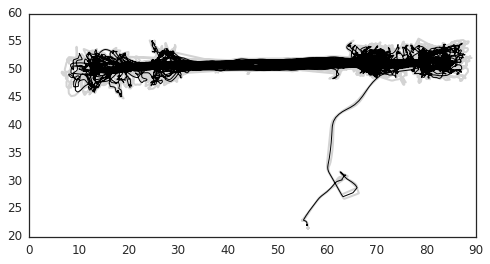

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from pandas import Series, DataFrame

%matplotlib inline


# read trajectory:
df1whl = pd.read_table( '../../Data/Buzsaki/gor01-6-7/2006-6-7_11-26-53/2006-6-07_11-26-53.whl',sep='\t', skiprows=0, names=['x1', 'y1', 'x2', 'y2'] )
df2whl = pd.read_table( '../../Data/Buzsaki/gor01-6-7/2006-6-7_16-40-19/2006-6-07_16-40-19.whl',sep='\t', skiprows=0, names=['x1', 'y1', 'x2', 'y2'] )
    
# plot trajectory:
sns.set(rc={'figure.figsize': (8, 4),'lines.linewidth': 1, 'font.size': 16, 'axes.labelsize': 14, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style("white")
palette = sns.color_palette()
plt.plot( df2whl['x1'], df2whl['y1'], linewidth=2, color='lightgray');
plt.plot( df2whl['x2'], df2whl['y2'], linewidth=2, color='lightgray');
plt.plot( (df2whl['x1'] + df2whl['x2'])/2, (df2whl['y1'] + df2whl['y2'])/2, linewidth=1, color='k' );

## Visualize position along the x-axis over time, to see how many runs were performed:

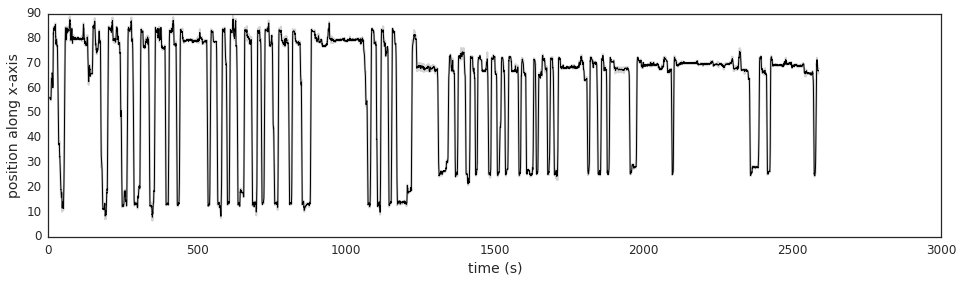

In [3]:
sns.set(rc={'figure.figsize': (16, 4),'lines.linewidth': 1.5, 'font.size': 16, 'axes.labelsize': 14, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style("white")
f, ( ax1 ) = plt.subplots(1,1)

ax1.plot(np.linspace(0,len(df2whl.index)/60,len(df2whl.index)),df2whl['x1'], linewidth=2, color='lightgray' )
ax1.plot(np.linspace(0,len(df2whl.index)/60,len(df2whl.index)),df2whl['x2'], linewidth=2, color='lightgray' )
ax1.plot(np.linspace(0,len(df2whl.index)/60,len(df2whl.index)),(df2whl['x1'] + df2whl['x2'])/2, linewidth=1, color='k' )
#ax1.set_xlim([0,2500])
ax1.set_xlabel('time (s)')
ax1.set_ylabel('position along x-axis')

#saveFigure("figures/x-pos vs time.pdf")


## Load spikes from LinearTwo:
I chose to use (as far as I could) data from LinearTwo, since the position data for LinearOne on the first session day are incomplete...

In [4]:
import pickle

#with open('../../Data/st_array1rn.pickle', 'rb') as f:
#    st_array1 = pickle.load(f)
with open('data/st_array2rn.pickle', 'rb') as f:
    st_array2 = pickle.load(f)

## Load Python modules and helper functions

In [5]:
import sys
sys.path.insert(0, '../')

import numpy as np
import pandas as pd
import pickle 
import seaborn as sns
#import yahmm as ym

from matplotlib import pyplot as plt
from pandas import Series, DataFrame

from efunctions import * # load my helper functions

%matplotlib inline

from scipy.signal import butter, lfilter, filtfilt

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filtfilt(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    #y = lfilter(b, a, data)
    y = filtfilt(b, a, data, padlen=150)
    return y

def rms(x):
    return np.sqrt(np.mean(x**2))

def compute_rolling_rms(x,fs,wt=10):
    # fs = sampling frequency
    # wt = sliding window over which to compute rms, in milliseconds
    
    nsamples = len(x)
    
    from collections import deque
    import itertools

    dqfilt = deque(x)
    x_rms = np.zeros(nsamples)
    wn = round(fs/1000*wt)    # number of samples per window to compute RMS power in

    for e in np.arange(nsamples):
        x_rms[e] = rms(np.array(list(itertools.islice(dqfilt, 1, wn+1))))
        dqfilt.rotate(-1)
    
    return x_rms

function saveFigure(filename) loaded

Tip: to save a figure, call saveFigure("path/figure.pdf")


## Build place field map for LinearTwo using only x-coords
1. estimate instantaneous running velocity at 60 Hz
2. smooth running velocity with a zero-phase filter
3. consider only spikes corresponding to bins where the instantaneous velocity is above some threshold (3 cm/s?)
4. determine the number of spikes per position bin, and the duration spent in that bin (all on the suprathreshold data)
5. smooth place fields again? using a Gaussian kernel?

In [6]:
# speed as a function of time...

def get_smooth_speed(x,y,fs=60,th=3,cutoff=0.5,showfig=False):
    dx = np.ediff1d(x,to_begin=0)
    dy = np.ediff1d(y,to_begin=0)
    dvdt = np.sqrt(np.square(dx) + np.square(dy))*60 # cm per second
    t0 = 0
    tend = len(dvdt)/fs # end in seconds

    cutoff=0.5
    dvdtlowpass = np.fmax(0,butter_lowpass_filtfilt(dvdt, cutoff=cutoff, fs=fs, order=6))

    print('The animal (gor01) ran an average of {0:2.2f} cm/s'.format(dvdt.mean()))

    #th = 3 #cm/s
    runindex = np.where(dvdtlowpass>=th); runindex = runindex[0]
    print("The animal ran faster than th = {0:2.1f} cm/s for a total of {1:2.1f} seconds (out of a total of {2:2.1f} seconds).".format(th,len(runindex)/60,len(centerx)/60))
    
    if showfig:
        sns.set(rc={'figure.figsize': (15, 4),'lines.linewidth': 3, 'font.size': 18, 'axes.labelsize': 16, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
        sns.set_style("white")

        f, (ax1, ax2) = plt.subplots(1,2)

        ax1.plot(np.arange(0,len(dvdt))/fs,dvdt,alpha=1,color='lightgray',linewidth=2)
        ax1.plot(np.arange(0,len(dvdt))/fs,dvdtlowpass, alpha=1,color='k',linewidth=1)
        ax1.set_xlabel('time (seconds)')
        ax1.set_ylabel('instantaneous velocity (cm/s)')
        ax1.legend(['unfiltered', str(cutoff) + ' Hz lowpass filtfilt'])
        ax1.set_xlim([0,2500])

        ax2.plot(np.arange(0,len(dvdt))/60,dvdt,alpha=1,color='lightgray',linewidth=2)
        ax2.plot(np.arange(0,len(dvdt))/60,dvdtlowpass, alpha=1,color='k',linewidth=1)
        ax2.set_xlabel('time (seconds)')
        ax2.set_ylabel('instantaneous velocity (cm/s)')
        ax2.legend(['unfiltered',  str(cutoff) + ' Hz lowpass filtfilt'])
        ax2.set_xlim([30,70])
  
    return dvdtlowpass, runindex

In [7]:
def list_of_spk_time_arrays_to_spk_counts_arrays(st_array_extern, ds=0, fs=0 ):
    """
    st_array: list of ndarrays containing spike times (in sample numbers!)
    ds:       delta sample number; integer value of samples per time bin
    fs:       sampling frequency
    
    argument logic: if only st_array is passed, use default ds; if ds is passed, use as is and ignore fs; if ds and fs are passed, use ds as time in seconds
    
    returns a (numBins x numCell) array with spike counts
    """
    
    st_array = st_array_extern
    
    if fs == 0:
        if ds == 0:
            ds = 1000 # assume default interval size
    else: # sampling frequency was passed, so interpret ds as time-interval, and convert accordingly:
        if ds == 0:
            ds = 1000 # assume default interval size
        else:
            ds = round(ds*fs)
            
    # determine number of units:
    num_units = len(st_array)
    
    #columns = np.arange(0,num_units)
    #df = DataFrame(columns=columns)
    
    maxtime = 0
    for uu in np.arange(num_units):
        try:
            maxtime = max(st_array[uu].max(), maxtime)
        except:
            maxtime = maxtime
    
    # create list of intervals:
    intlist = np.arange(0,maxtime,ds)
    num_bins = len(intlist)
    
    spks_bin = np.zeros((num_bins,num_units))
    
    print("binning data into {0} x {1:2.1f} ms temporal bins...".format(num_bins, ds*1000/fs))
    
    for uu in np.arange(num_units):
        # count number of spikes in an interval:
        spks_bin[:,uu] = np.histogram(st_array[uu], bins=num_bins, density=False, range=(0,maxtime))[0]
        #spk_count_list.append([x&y for (x,y) in zip(st_array[uu]>ii, st_array[uu] < ii+ds)].count(True))
        #st_array[uu] = st_array[uu][st_array[uu]>ii+ds]        
        #if df.empty:
        #    df = DataFrame([spk_count_list], columns=columns)
        #else:
        #    df = df.append(DataFrame([spk_count_list], columns=columns),ignore_index=True)
                    
    return spks_bin

The animal (gor01) ran an average of 2.89 cm/s
The animal ran faster than th = 3.0 cm/s for a total of 533.6 seconds (out of a total of 2587.8 seconds).
binning data into 155135 x 16.7 ms temporal bins...


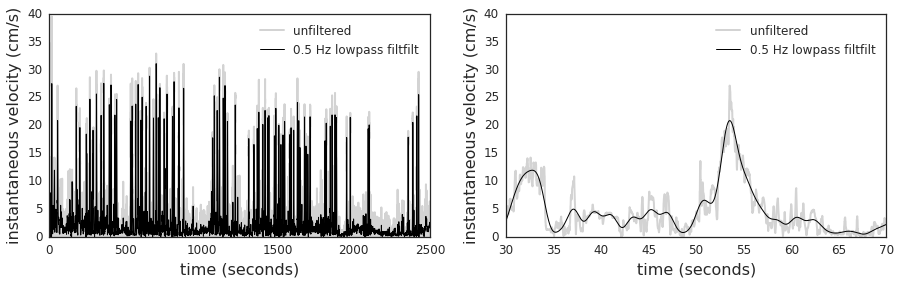

In [8]:
centerx = (np.array(df2whl['x1']) + np.array(df2whl['x2']))/2
centery = (np.array(df2whl['y1']) + np.array(df2whl['y2']))/2

binned_vel_60Hz, binned_runidx_60Hz = get_smooth_speed(centerx,centery,fs=60,th=3,showfig=True)
binned_counts_60Hz = list_of_spk_time_arrays_to_spk_counts_arrays(st_array2, ds=0.016666667, fs=32552)

# trim run indices to same length as spike counts
binned_runidx_60Hz = binned_runidx_60Hz[np.where(binned_runidx_60Hz<len(binned_counts_60Hz))[0]]; # runindexnew = runindexnew[0]

# get bins of spk counts that correspond to where the animal was running above threshold:
binned_counts_60Hz_run = binned_counts_60Hz[binned_runidx_60Hz,:]

In [9]:
def estimate_place_fields(binned_pos,binned_spk_cnts,fs,x0,xl,num_pos_bins=200,minth=0.005,max_meanfiringrate=4,min_maxfiringrate=2,sigma=1):
    
    from scipy.ndimage.filters import gaussian_filter1d
    #num_bins = 200 # position bins for place fields
    #x0 = 0
    #xl = 100

    num_units = len(binned_spk_cnts[0])

    #data = (np.array(df2whl['x1'])[runindex] + np.array(df2whl['x2'])[runindex])/2

    bins = np.linspace(x0,xl,num_pos_bins)
    digitized = np.digitize(binned_pos, bins) # bin numbers
    bin_cnt = [len(binned_pos[digitized == i]) for i in range(0, len(bins)-1)]
    bin_time = [b/fs for b in bin_cnt] # convert to seconds spent in bin
    
    pfbincenters = bins[:-1] + np.diff(bins)/2

    pf2spk_cnt = np.zeros((num_pos_bins,num_units))
    closest_bins = np.digitize(binned_pos,bins)
   
    for cnt, bb in enumerate(closest_bins):
        pf2spk_cnt[bb,:] += binned_spk_cnts[cnt,:]
        
    sns.set(rc={'figure.figsize': (15, 4),'lines.linewidth': 3, 'font.size': 18, 'axes.labelsize': 16, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
    sns.set_style("white")
    
    fig, ax1 = plt.subplots()
    
    ax1.plot(pf2spk_cnt, 'gray', linewidth=1)
    #DEBUG: plot only cells 11 and 20 for debugging...
    #ax1.plot(pf2spk_cnt[:,[11,20]], 'gray', linewidth=1)
    ax1.set_xlabel('position (cm)')
    # Make the y-axis label and tick labels match the line color.
    ax1.set_ylabel('spikes per bin', color='gray')
    for tl in ax1.get_yticklabels():
        tl.set_color('gray')
    
    ax2 = ax1.twinx()
    ax2.plot(bin_time,'k',linewidth=2,marker='o')
    ax2.set_ylabel('time spent in position bin (sec)', color='k')
    for tl in ax2.get_yticklabels():
        tl.set_color('k')
    
    #plt.plot(pf2spk_cnt,'gray',linewidth=1)
    
    pf2 = []
    pfsmooth = []
#    minth = 0.05 # min threshold for backgrnd spking actvy
    for uu in np.arange(0,num_units):
        pf2.append([b/max(c,1/fs) for (b,c) in zip(pf2spk_cnt[:,uu],bin_time)])
        pfsmooth.append(gaussian_filter1d(pf2[uu], sigma=sigma))
        
        #pfsmooth.append(butter_lowpass_filtfilt(pf2[uu], cutoff=15, fs=200, order=4))

    pfsmooth = np.array(pfsmooth)
    pfsmooth[pfsmooth<minth] = minth # enforce a minimum background firing rate.
    
    # throw away cells that look like interneurons, or cells that are inactive throughout the entire experiment:
    meanfiringrates = pfsmooth.mean(axis=1)
    maxfiringrates = pfsmooth.max(axis=1)

#    max_meanfiringrate = 4 # Hz
#    min_maxfiringrate = 2 # Hz

    pindex = np.where((meanfiringrates<=max_meanfiringrate) & (maxfiringrates>min_maxfiringrate)); pindex = pindex[0]
    print("{0} out of {1} cells passed the criteria to be place cells...".format(len(pindex),len(meanfiringrates)))

    return pfsmooth, pfbincenters, pindex

In [10]:
def show_place_fields(pfs, pfbincenters, pindex,min_maxfiringrate=0):
    
    meanfiringrates = pfs.mean(axis=1)
    maxfiringrates = pfs.max(axis=1)

    # visualize place fields

    # order remaining cells by peak hight along the track
    peaklocations = pfs.argmax(axis=1)
    peakorder = peaklocations[pindex].argsort()

    sns.set(rc={'figure.figsize': (15, 4),'lines.linewidth': 3, 'font.size': 18, 'axes.labelsize': 16, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
    sns.set_style("white")

    f, ( (ax1, ax2), (ax3, ax4) ) = plt.subplots(2,2)
    ax1.plot(meanfiringrates,linewidth=2,color='lightgray')
    ax1.plot(maxfiringrates,linewidth=1,color='k')
    ax1.legend(['mean firing rate','max firing rate'])
    ax1.set_title('mean and max firing rates of all cells')

    ax2.plot(meanfiringrates[pindex],linewidth=2,color='lightgray')
    ax2.plot(maxfiringrates[pindex],linewidth=1,color='k')
    ax2.legend(['mean firing rate','max firing rate'])
    ax2.set_title('mean and max firing rates of place cells')

    cell_list = pindex

    for uu in cell_list:
        ax3.plot(pfbincenters, pfs[uu], linewidth=1, color='k')

    plt.subplots_adjust(hspace=0.40)
    #ax3.set_title("place fields in LinearTwo",fontsize=14)
    ax1.set_ylabel("firing rate (Hz)")
    ax2.set_ylabel("firing rate (Hz)")
    ax3.set_ylabel("firing rate (Hz)")
    ax3.set_xlim([0,100])
    ax3.set_title('Place fields of place cells')
    
    sns.set(rc={'figure.figsize': (4,8),'lines.linewidth': 3, 'font.size': 18, 'axes.labelsize': 16, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
    sns.set_style("white")

    f, axes = plt.subplots(len(pindex), sharex=True, sharey=True)
    plt.subplots_adjust(hspace=0.100)

    for ii,pp in enumerate(pindex[peakorder]):
        axes[ii].plot((0, 100), (min_maxfiringrate, min_maxfiringrate), 'k:', linewidth=1)
        axes[ii].plot(pfbincenters, pfs[pp],linewidth=1,color='k')
        axes[ii].fill_between(pfbincenters, 0, pfs[pp], color='gray')
        axes[ii].set_xticks([])
        axes[ii].set_yticks([])
        axes[ii].spines['top'].set_visible(False)
        axes[ii].spines['right'].set_visible(False)
        axes[ii].spines['bottom'].set_visible(False)
        axes[ii].spines['left'].set_visible(False)
        axes[ii].set_ylabel(pp, fontsize=12)
        axes[ii].set_ylim([0,15])

    axes[-1].set_xticks([10,50,90])
    axes[-1].set_xlabel('position along track [cm]')
    f.suptitle('Place fields ordered by peak location along track, cells are zero-indexed.')

28 out of 90 cells passed the criteria to be place cells...


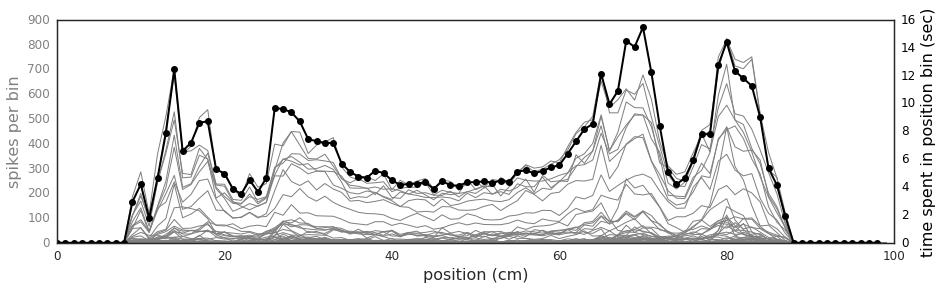

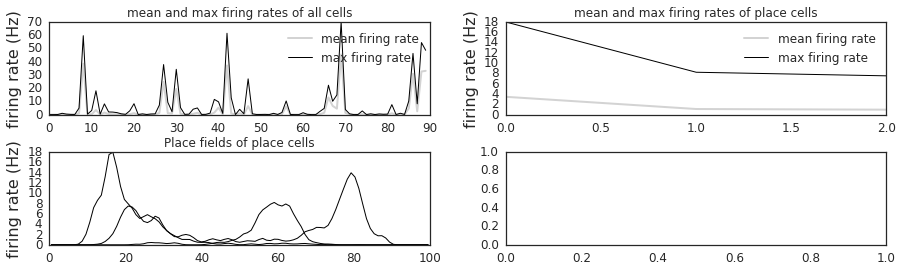

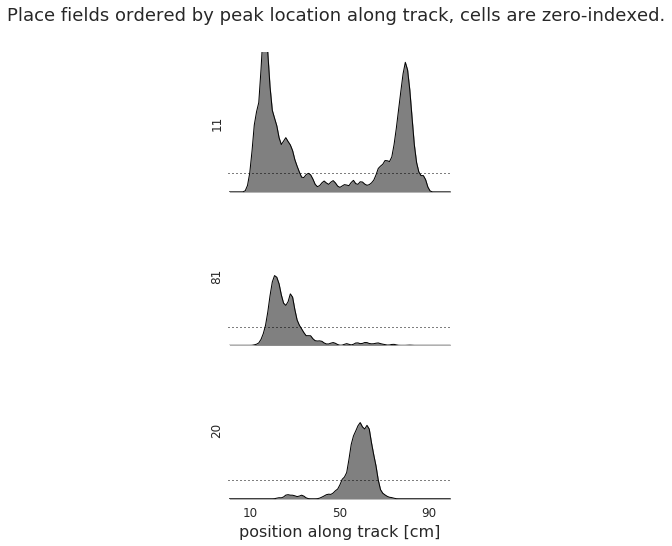

In [11]:
binned_runposx_60Hz = centerx[binned_runidx_60Hz]

pfs, pfbincenters, pindex = estimate_place_fields(binned_runposx_60Hz,binned_counts_60Hz_run,fs=60, x0=0,xl=100,max_meanfiringrate = 4,min_maxfiringrate=1,num_pos_bins=100,sigma=1)

#show_place_fields(pfs,pfbincenters,pindex)
show_place_fields(pfs,pfbincenters,np.array([11,20,81]),min_maxfiringrate=2)


## Load eeg data for SWR detection

In [12]:
num_channels = 96
#dt = np.dtype([('a', 'i2', (num_channels,))])
dtype = np.dtype([(('ch' + str(ii)), 'i2')  for ii in range(num_channels) ])

# read eeg data:
eegdata = np.fromfile('../../Data/Buzsaki/gor01-6-7/2006-6-7_16-40-19/2006-6-7_16-40-19.eeg', dtype=dtype, count=-1)
    

## Create dataframes containing EEG data, with one column for each of the 96 channels
As above, the code below can be improved by wrapping it in a function, and automatically extracting the starting time from the filename, etc.

In [13]:
fs = 1252 # eeg sampling frequency [Hz]

num_records = len(eegdata)
reltime = np.arange(num_records) / fs
#times = map(lambda x:dt.timedelta(seconds=x), reltime)
starttime = pd.to_datetime('200667164019', format='%Y%m%d%H%M%S')
times = map(lambda x:starttime + pd.tseries.timedeltas.to_timedelta(x, unit='s') , reltime)
# transform from record array to ndarray:
data_arr = eegdata.astype(dtype).view('i2')
# reshape data into dataframe size:
data_arr = data_arr.reshape(num_records,num_channels)
# delete 'data', as memory can be an issue here...
del eegdata
# create DataFrame from ndarray:
df = pd.DataFrame(data_arr, index=times, columns=dtype.names) # contains raw eeg data for all channels


NOTE: above functions take quite a while (2+ minutes?) to complete... Consider re-writing without Pandas and timestamps for improved speed...

## Filter EEG data for frequency range that is of relevance for SWR detection

### NOTE: we use only one channel to look for SWRs
Currently the choice of which channel to use is somewhat arbitrary...

In [14]:
# choose EEG channel to use to look for SWR events:
ch = 'ch1'

# extract single EEG channel
x_unfilt = df[ch].values
x_unfilt = x_unfilt.astype(int) # convert from int16 to int to prevent overflow when calling e.g. rms(); we don't actually use it like that though...
del df # delete dataframe, since all we need is x_unfilt

# Sample rate and desired cutoff frequencies (in Hz).
fs = 1252.0
lowcut = 150.0
highcut = 250.0

In [15]:
import scipy.signal as signal
import matplotlib.pyplot as plt
import scipy.io

/home/ubuntu/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


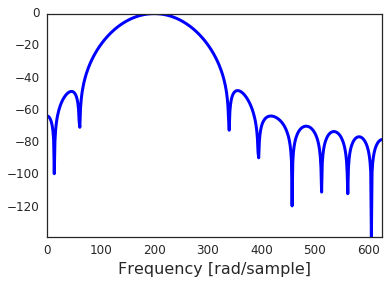

In [16]:
%matplotlib inline

b = signal.firwin(25, [lowcut/(fs/2), highcut/(fs/2)], pass_zero=False)
w,h = signal.freqz(b)
fig = plt.figure()
plt.plot(w/np.pi*(fs/2), 20 * np.log10(abs(h)), 'b')
plt.xlabel('Frequency [rad/sample]')
plt.axis('tight')
fig.show()

In [17]:
ripple_data = signal.filtfilt(b,1,x_unfilt)

In [18]:
ripple_envelope = np.absolute(signal.hilbert(ripple_data))

In [19]:
import scipy.ndimage
SD = 0.004 * fs
smoothed_envelope = scipy.ndimage.filters.gaussian_filter1d(ripple_envelope, SD,mode='constant')

In [20]:
from itertools import groupby
from operator import itemgetter

def find_threshold_crossing_events(x, threshold) :
    above_threshold = np.where(x > threshold, 1, 0);
    eventlist = []
    eventmax = []
    for k,v in groupby(enumerate(above_threshold),key=itemgetter(1)):
        if k:
            v = list(v)
            eventlist.append([v[0][0],v[-1][0]])
            try :
                eventmax.append(x[v[0][0]:(v[-1][0]+1)].max())
            except :
                print(v, x[v[0][0]:v[-1][0]])
                
    eventmax = np.asarray(eventmax)
    eventlist = np.asarray(eventlist)
    return eventlist, eventmax

In [21]:
# Find periods where value is > mean + 3 SD
ripple_events = find_threshold_crossing_events(smoothed_envelope,
                                 np.mean(smoothed_envelope) + 3*np.std(smoothed_envelope))[0]

LengthCriteria = 0.015

# Purge ripple events which aren't long enough (15 ms)
ripple_events = \
    ripple_events[ripple_events[:,1] - ripple_events[:,0] > np.round(fs*LengthCriteria),:]


# Find periods where value is > mean; note that the previous periods should be within these!
ripple_bounds, broader_maxes = find_threshold_crossing_events(smoothed_envelope, 
                                                  np.mean(ripple_envelope))

In [22]:
# Find corresponding big windows for potential ripple events
#  Specifically, look for closest left edge that is just smaller
outer_boundary_indices = np.searchsorted(ripple_bounds[:,0], ripple_events[:,0]);
#  searchsorted finds the index after, so subtract one to get index before
outer_boundary_indices = outer_boundary_indices - 1;

# Find extended boundaries for ripple events by pairing to larger windows
#   (Note that there may be repeats if the larger window contains multiple > 3SD sections)
ripple_bounds = ripple_bounds[outer_boundary_indices,:]
ripple_maxes = broader_maxes[outer_boundary_indices]

# Now, since all that we care about are the larger windows, so we should get rid of repeats
_, unique_idx = np.unique(ripple_bounds[:,0], return_index=True)
ripple_bounds = ripple_bounds[unique_idx,:]
ripple_maxes = ripple_maxes[unique_idx]
ripple_events = ripple_events[unique_idx,:]

In [23]:
StartTime = 0
ripple_centers = (ripple_bounds[:,1]/2 + ripple_bounds[:,0]/2) / fs + StartTime

In [24]:
ripple_bounds[:5,:]/fs # ripple bounds in seconds

array([[  1.06709265,   1.11421725],
       [  9.0399361 ,   9.23083067],
       [  9.23722045,   9.32747604],
       [ 45.4928115 ,  45.54472843],
       [ 62.33306709,  62.38258786]])

In [25]:
# create SWR_events dataframe with all possible SWR events
SWR_events = pd.DataFrame(ripple_bounds,columns=['start','end'])
SWR_events['duration_ms'] = (SWR_events.end - SWR_events.start) / fs * 1000
SWR_events['n_active_cells'] = np.nan
SWR_events['corr'] = np.nan
SWR_events['maxdist'] = np.nan
SWR_events['s_ctx'] = np.nan
SWR_events['s_seq'] = np.nan
SWR_events['replay'] = np.nan
print(SWR_events[0:10])
print('...')

    start     end  duration_ms  n_active_cells  corr  maxdist  s_ctx  s_seq  \
0    1336    1395    47.124601             NaN   NaN      NaN    NaN    NaN   
1   11318   11557   190.894569             NaN   NaN      NaN    NaN    NaN   
2   11565   11678    90.255591             NaN   NaN      NaN    NaN    NaN   
3   56957   57022    51.916933             NaN   NaN      NaN    NaN    NaN   
4   78041   78103    49.520767             NaN   NaN      NaN    NaN    NaN   
5   83438   83513    59.904153             NaN   NaN      NaN    NaN    NaN   
6   84131   84191    47.923323             NaN   NaN      NaN    NaN    NaN   
7  109471  109543    57.507987             NaN   NaN      NaN    NaN    NaN   
8  110380  110460    63.897764             NaN   NaN      NaN    NaN    NaN   
9  110753  110878    99.840256             NaN   NaN      NaN    NaN    NaN   

   replay  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN  
5     NaN  
6     NaN  
7     NaN  
8     NaN  
9     NaN 

In [26]:
# this is a little helper function that can be used similar to MATLAB's find(), except that it returns all the
# indices, and cannot be stopped after finding just the first, for example.
# usage example: idx = indices(input_array, lambda x: x > pos)[0]

def indices(a, func):
    return [i for (i, val) in enumerate(a) if func(val)]

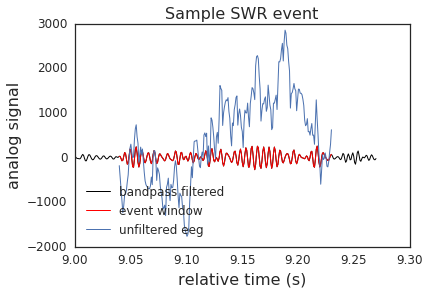

In [27]:
# plot one of the putative sharp wave ripple events:
sns.set(rc={'figure.figsize': (6, 4),'lines.linewidth': 1, 'font.size': 18, 'axes.labelsize': 16, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style("white")

swr_idx = 1
xflong = ripple_data[ripple_bounds[swr_idx,0]-50:ripple_bounds[swr_idx,1]+50]
xf = ripple_data[ripple_bounds[swr_idx,0]:ripple_bounds[swr_idx,1]]
xu = x_unfilt[ripple_bounds[swr_idx,0]:ripple_bounds[swr_idx,1]]

nsamples = len(xflong)
Tlong = nsamples/fs
tstart = (ripple_bounds[swr_idx,0]-50) / fs
tlong = np.linspace(tstart, tstart + Tlong, nsamples, endpoint=False)

nsamples = len(xf)
T = nsamples/fs
tstart = (ripple_bounds[swr_idx,0]) / fs
t = np.linspace(tstart, tstart + T, nsamples, endpoint=False)

plt.plot(tlong,xflong,'k')
plt.plot(t,xf,'r')
plt.plot(t,xu)
plt.xlabel('relative time (s)')
plt.ylabel('analog signal')
plt.title('Sample SWR event',fontsize=16)
plt.legend(['bandpass filtered','event window','unfiltered eeg'],loc=3)

#saveFigure("figures/sample-swr-event-eeg.pdf")

In [28]:
# restrict minimum and maximum SWR sequence durations...
min_swr_duration = 15 #ms
max_swr_duration = 500 #ms
SWR_events = SWR_events[(SWR_events['duration_ms']>=min_swr_duration) & (SWR_events['duration_ms']<=max_swr_duration)]
SWR_events.reset_index(drop=True, inplace=True)

print('A total of {0} SWR sequences passed the length requirements...\n'.format(SWR_events.index[-1]))
print(SWR_events[0:10])
print('...')

A total of 665 SWR sequences passed the length requirements...

    start     end  duration_ms  n_active_cells  corr  maxdist  s_ctx  s_seq  \
0    1336    1395    47.124601             NaN   NaN      NaN    NaN    NaN   
1   11318   11557   190.894569             NaN   NaN      NaN    NaN    NaN   
2   11565   11678    90.255591             NaN   NaN      NaN    NaN    NaN   
3   56957   57022    51.916933             NaN   NaN      NaN    NaN    NaN   
4   78041   78103    49.520767             NaN   NaN      NaN    NaN    NaN   
5   83438   83513    59.904153             NaN   NaN      NaN    NaN    NaN   
6   84131   84191    47.923323             NaN   NaN      NaN    NaN    NaN   
7  109471  109543    57.507987             NaN   NaN      NaN    NaN    NaN   
8  110380  110460    63.897764             NaN   NaN      NaN    NaN    NaN   
9  110753  110878    99.840256             NaN   NaN      NaN    NaN    NaN   

   replay  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     

In [29]:
# WARNING! 
# SWR_events are in sample #s with fs = 1252, whereas st_array spike times are in sample #s with fs = 32552

fsEEG = 1252
fsSpikes = 32552

st_array_fsEEG = [x*(fsEEG/fsSpikes) for x in st_array2] # spike times in fsEEG sample numbers (not integral)

In [30]:
# extract observation sequences corresponding to SWR events
def extract_and_bin_spikes_during_swr_events(SWR_events, st_arrayfsEEG, bintime = 10):

    # bintime in milliseconds
    from math import ceil
    # given SWR_ch1_events (dataframe) and st_array1fsEEG and st_array2fsEEG, we build the list of lists of lists of arrays:

    #bintime = 10 # bin time in ms, has to be small to work with replay


    N = len(SWR_events.index) # number of SWR events
    num_units = len(st_arrayfsEEG) # number of units
    spk_cnters = np.zeros((num_units,1),dtype=np.int32)

    SWRspikes = []
    idx = -1
    for row in SWR_events.itertuples():
        _, start, stop, duration, _, _, _, _, _, _ = zip(row) # still tuples
        idx += 1; start = start[0]; stop = stop[0]; duration = duration[0]
        # determine sequence length in number of bins:
        num_bins = ceil(duration/bintime)
        SWRspikes.append([]) # list for idx=nth SWR event
        for bb in np.arange(0,num_bins):
            SWRspikes[idx].append([]) # add list element for each bin in sequence
            for uu in np.arange(0,num_units):
                # count spikes in bin and advance spike time array counter to make subsequent searches faster:
                spk_cnters[uu][0] = spk_cnters[uu][0] + len(st_arrayfsEEG[uu][spk_cnters[uu][0]:][st_arrayfsEEG[uu][spk_cnters[uu][0]:]<start+(bb)*bintime])
                #debug#print("skip first {0} spikes for unit {1}...".format(spk_cnters[uu][0],uu))
                tempspikes = st_arrayfsEEG[uu][spk_cnters[uu][0]:][st_arrayfsEEG[uu][spk_cnters[uu][0]:]<=start+(bb+1)*bintime]
                numspikes = len(tempspikes)
                #debug#print("spikes in bin {0} of unit {1}: {2}".format(bb,uu,numspikes))
                SWRspikes[idx][bb].append(np.array(numspikes))
                
    return SWRspikes

#SWRspikes = extract_and_bin_spikes_during_swr_events( SWR_events1, st_array_fsEEG1, bintime = 5 )

In [31]:
#binned_counts_5ms = list_of_spk_time_arrays_to_spk_counts_arrays(st_array2, ds=0.005, fs=32552)
binned_counts_5ms_SWR = extract_and_bin_spikes_during_swr_events( SWR_events, st_array_fsEEG, bintime = 5 )

## All the sequences in binned_counts_5ms_SWR are now ready to scale-and-evaluate in a trained BVR HMM, as well as for decoding using the Bayesian decoder, followed by the correlation analysis.

In [32]:
# determine the number of active cells in each event:
for kk, seq in enumerate(binned_counts_5ms_SWR):
    ndseq = np.array(seq)
    SWR_events.ix[kk,'n_active_cells'] = np.count_nonzero(ndseq.sum(axis=0)[pindex])

In [33]:
SWR_events[:10]

,start,end,duration_ms,n_active_cells,corr,maxdist,s_ctx,s_seq,replay
0,1336,1395,47.124601,2,NaN,NaN,NaN,NaN,NaN
1,11318,11557,190.894569,6,NaN,NaN,NaN,NaN,NaN
2,11565,11678,90.255591,3,NaN,NaN,NaN,NaN,NaN
3,56957,57022,51.916933,2,NaN,NaN,NaN,NaN,NaN
4,78041,78103,49.520767,4,NaN,NaN,NaN,NaN,NaN
5,83438,83513,59.904153,6,NaN,NaN,NaN,NaN,NaN
6,84131,84191,47.923323,4,NaN,NaN,NaN,NaN,NaN
7,109471,109543,57.507987,1,NaN,NaN,NaN,NaN,NaN
8,110380,110460,63.897764,6,NaN,NaN,NaN,NaN,NaN
9,110753,110878,99.840256,8,NaN,NaN,NaN,NaN,NaN


In [34]:
# require at least five PLACE CELLS to be active...
SWR_cand_events = SWR_events[SWR_events.n_active_cells>4]
SWR_cand_events.head()

,start,end,duration_ms,n_active_cells,corr,maxdist,s_ctx,s_seq,replay
1,11318,11557,190.894569,6,NaN,NaN,NaN,NaN,NaN
5,83438,83513,59.904153,6,NaN,NaN,NaN,NaN,NaN
8,110380,110460,63.897764,6,NaN,NaN,NaN,NaN,NaN
9,110753,110878,99.840256,8,NaN,NaN,NaN,NaN,NaN
18,128203,128302,79.073482,5,NaN,NaN,NaN,NaN,NaN


In [35]:
binned_counts_5ms_SWR_cand_events = extract_and_bin_spikes_during_swr_events( SWR_cand_events, st_array_fsEEG, bintime = 5 )

**NOTE:** binned_counts_5ms_SWR_cand_events now contains all the candidate events for further processing...

In [36]:
# NOTE: if a sequence is stationary (no movement) then corrXYprob evaluates to nan...
def mXprob(X,prob):
    den = prob.sum()
    num = (prob*X).sum()
    return num/den

def covXYprob(X,Y,prob):
    den = prob.sum()
    num = (prob*(X - mXprob(X,prob))*(Y - mXprob(Y,prob))).sum()
    return num/den

def corrXYprob(X,Y,prob):
    # ignore empty time bins:
    X = X[~np.isnan(prob)]; Y = Y[~np.isnan(prob)]; prob = prob[~np.isnan(prob)]
    den = np.sqrt(covXYprob(X,X,prob)*covXYprob(Y,Y,prob))
    num = covXYprob(X,Y,prob)
    return num/den

In [37]:
# note that here we re-sample placefields simply with linear interpolation. A more 'accurate' approach might be to compute the mean firing rate within each new bin...
def resample_placefields(pfsmooth, s_bin, pfbincenters, x0,xl):
    newx = np.arange(x0,xl,s_bin) + s_bin/2
    ss_pfsmooth = np.zeros((pfsmooth.shape[0],len(newx)))
    for cc in np.arange(0,pfsmooth.shape[0]):
        ss_pfsmooth[cc,:] = np.interp(newx,pfbincenters,pfsmooth[cc,:])
    return ss_pfsmooth, newx

def resample_velocity(velocity, t_bin, tvel, t0,tend):
    newt = np.arange(t0,tend,t_bin) + t_bin/2
    newvel = np.zeros((1,len(newt)))
    newvel = np.interp(newt,tvel,velocity)
    return newvel, newt

Decoding with 4 x 5.0 ms bins per window, into one of 200 spatial bins with size 0.5 cm each...
-0.237471336401
-0.159195915753


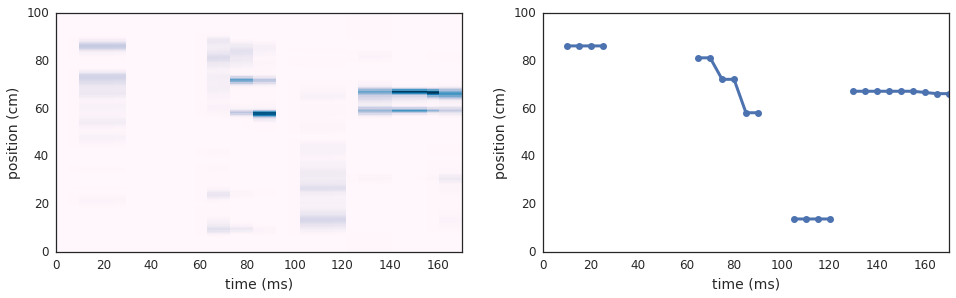

In [38]:
def decode_swr_sequence(seq,pfs,pfbincenters,pindex,t_bin,tau,showfig=False,shuffletype='none'):
    
    # decode a sequence of observations using 20 ms window with 5 ms sliding window increments
    
    #n  C x 1        changes every time step
    #fi C x 1        never changes
    #f  C x nbins    never changes

    seq = np.array(seq)
    bins_per_window = round(tau/t_bin)
    num_tbins=len(seq)
    PP = np.zeros((len(pfbincenters),num_tbins-bins_per_window))
    f = pfs[pindex,:]
    if shuffletype == 'unit-all':
        np.random.shuffle(pindex) # unit identity shuffle using ALL place cells
    elif shuffletype == 'unit-event':
        # determine which place cells participate in the event:
        eventpcells = pindex[np.nonzero(seq.sum(axis=0)[pindex])]
        # unit identity shuffle using only participating place cells
        np.random.shuffle(eventpcells)
        pindex[np.nonzero(seq.sum(axis=0)[pindex])] = eventpcells
    dec_pos = np.zeros((num_tbins-bins_per_window,1))
    prob = np.zeros((num_tbins-bins_per_window,1))
    est_pos_idx = 0
        
    for tt in np.arange(0,num_tbins-bins_per_window): #len(spk_counts2_5ms_run)-4):
        #tt+=1 # time index
        n = seq[tt:tt+bins_per_window,pindex].sum(axis=0)
        nn = np.tile(n,(len(ss_pfbincenters),1)).T
        if nn.max() == 0:
            #print('No spikes in decoding window, so cannot decode position!')
            PP[:,tt] = PP[:,tt]
            est_pos_idx = np.nan
            dec_pos[tt] = np.nan
            prob[tt] = np.nan
        else:
            #print('Some spikes detected in decoding window.. yeah!!!')
            PP[:,tt] = np.exp((np.log((f)**(nn))).sum(axis=0) - tau*f.sum(axis=0))
            PP[:,tt] = PP[:,tt]/PP[:,tt].sum() # normalization not strictly necessary
            est_pos_idx = PP[:,tt].argmax()
            dec_pos[tt] = ss_pfbincenters[est_pos_idx]
            prob[tt] = PP[est_pos_idx,tt]
    T = np.arange(0,num_tbins-bins_per_window)*t_bin*1000
    T = T.reshape((len(T),1))
    
    if showfig:
        sns.set(rc={'figure.figsize': (16, 6),'lines.linewidth': 3, 'font.size': 16, 'axes.labelsize': 14, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
        sns.set_style("white")
        f, (ax1, ax2) = plt.subplots(1,2)

        x0=0
        xl=np.ceil(pfbincenters[-1]/10)*10
        tend=num_tbins*5
        extent=(0,T[-1],x0,xl)
        ax1.imshow(PP,cmap='PuBu',origin='lower',extent=extent,interpolation='none')
        yticks=np.arange(x0,xl+1,20)
        ax1.set_yticks(yticks)
        ax1.set_ylabel('position (cm)')
        ax1.set_xlabel('time (ms)')
        ax2.plot(T, dec_pos,marker='o')
        ax2.set_aspect('equal')
        ax2.set_ylim([x0,xl])
        ax2.set_xlim([0,T[-1]])
        ax2.set_yticks(yticks)
        ax2.set_ylabel('position (cm)')
        ax2.set_xlabel('time (ms)')
    
    return T, dec_pos, prob, PP


s_bin = 0.5 # cm of spatial bins
ss_pfsmooth, ss_pfbincenters = resample_placefields(pfs, s_bin, pfbincenters, x0=0, xl=100)#super-sampled or sub-sampled smoothed place fields

t_bin = 0.005 # sec; temporal resolution for binning spikes
#ss_spk_counts2 = list_of_spk_time_arrays_to_spk_counts_arrays(st_array2, ds=t_bin, fs=32552)

tau = 0.02   # sec (decoding time window)
#bins_per_window = round(tau/t_bin)

t_bin = 0.005 # sec; temporal resolution for binning spikes
#ss_spk_counts2 = list_of_spk_time_arrays_to_spk_counts_arrays(st_array2, ds=t_bin, fs=32552)

tau = 0.02   # sec (decoding time window)
bins_per_window = round(tau/t_bin)
print("Decoding with {0} x {1} ms bins per window, into one of {2} spatial bins with size {3} cm each...".format(bins_per_window,t_bin*1000,len(ss_pfbincenters),s_bin))
    
# decode SWR trajectory:
seqidx=0
seq = binned_counts_5ms_SWR_cand_events[seqidx]
T, P, prob, PP = decode_swr_sequence(seq,ss_pfsmooth,ss_pfbincenters,pindex,t_bin=t_bin,tau=tau,showfig=True,shuffletype='none')
            
print(corrXYprob(T,P,prob))

# column-cycle shuffle:
newidx = np.random.random_integers(low=0, high=len(ss_pfbincenters)-1, size=(len(P),1))
P = ss_pfbincenters[newidx]
print(corrXYprob(T,P,prob))





In [39]:
def max_jump_dist(P):
    return np.diff(P[~np.isnan(P)]).max()
    

In [40]:
weighted_corr = []
ncbins = 20
weighted_corr_col_shuffl_hist = np.zeros((ncbins,1))
N_shuffl = 1000

max_dist = 100 #cm

cand_max_dist = []
cand_max_dist_hist = np.zeros((ncbins,1))
cand_max_dist_shffl_hist = np.zeros((ncbins,1))
dfindex = SWR_cand_events.index

for kk,seq in enumerate(binned_counts_5ms_SWR_cand_events):
    T, P, prob, PP = decode_swr_sequence(seq,ss_pfsmooth,ss_pfbincenters,pindex,t_bin=t_bin,tau=tau,showfig=False)
    tmpcorr = corrXYprob(T,P,prob)
    weighted_corr.append(tmpcorr)
    tmpdist = max_jump_dist(P)/ss_pfbincenters[-1]
    cand_max_dist.append(tmpdist)
    temp_corr = np.zeros(N_shuffl)
    temp_max = np.zeros(N_shuffl)
    for nn in np.arange(0,N_shuffl):
        # column-cycle shuffle:
        newidx = np.random.random_integers(low=0, high=len(ss_pfbincenters)-1, size=(len(P),1))
        Pshffl = ss_pfbincenters[newidx]
        temp_corr[nn] = corrXYprob(T,Pshffl,prob)
        temp_max[nn] = max_jump_dist(Pshffl)/ss_pfbincenters[-1]
        
    weighted_corr_col_shuffl_hist += (np.histogram(temp_corr,bins=ncbins, range=(-1,1))[0]).reshape(ncbins,1)
    cand_max_dist_shffl_hist += (np.histogram(temp_max,bins=ncbins, range=(0,1))[0]).reshape(ncbins,1)
    
    dfidx = dfindex[kk]
    SWR_cand_events.ix[dfidx,'corr'] = tmpcorr
    SWR_cand_events.ix[dfidx,'maxdist'] = tmpdist
    if np.abs(tmpcorr) >= 0.6 and tmpdist <= 0.4:
        SWR_cand_events.ix[dfidx,'replay'] = True
    else:
        SWR_cand_events.ix[dfidx,'replay'] = False
    
    
    
weighted_corr_col_shuffl_hist = weighted_corr_col_shuffl_hist/N_shuffl
weighted_corr_col_shuffl_hist = weighted_corr_col_shuffl_hist/weighted_corr_col_shuffl_hist.sum()
weighted_corr_hist, ncbin_edges = np.histogram(weighted_corr,bins=ncbins, range=(-1,1))
weighted_corr_hist = weighted_corr_hist/weighted_corr_hist.sum()

cand_max_dist_shffl_hist = cand_max_dist_shffl_hist/cand_max_dist_shffl_hist.sum()
cand_max_dist_hist, ncbin_max_edges = np.histogram(cand_max_dist,bins=ncbins, range=(0,1))
cand_max_dist_hist = cand_max_dist_hist/cand_max_dist_hist.sum()

print('{} out of {} candidate events classified as replay (trajectory) events...'.format(np.count_nonzero(SWR_cand_events.replay),SWR_cand_events.replay.count()))

# TODO: add sequence score

/home/ubuntu/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


72 out of 169 candidate events classified as replay (trajectory) events...


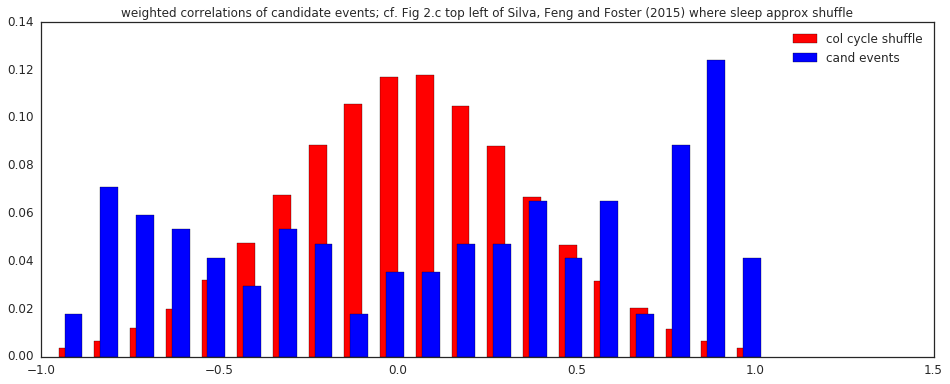

In [41]:
#sns.distplot(weighted_corr,bins=20, rug=True, kde=False, norm_hist=True)
plt.bar((ncbin_edges[1:] - np.diff(ncbin_edges)/2),weighted_corr_col_shuffl_hist,width=0.05,color='r')
plt.bar((ncbin_edges[1:] - np.diff(ncbin_edges)/3),weighted_corr_hist,width=0.05,color='b')
plt.legend(['col cycle shuffle','cand events'])
plt.title('weighted correlations of candidate events; cf. Fig 2.c top left of Silva, Feng and Foster (2015) where sleep approx shuffle')

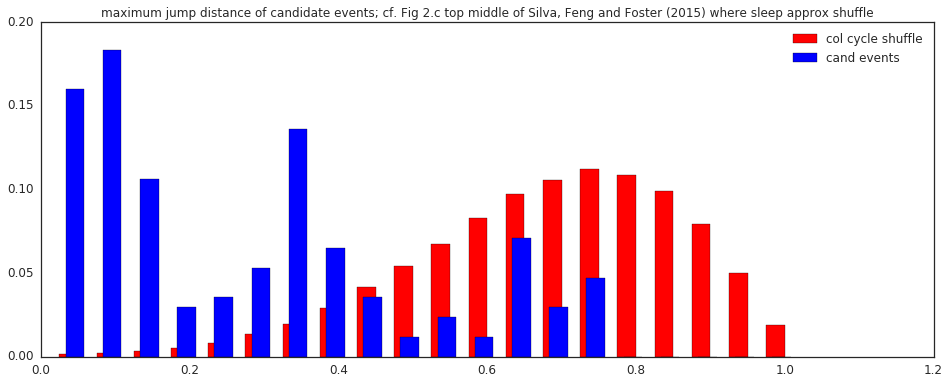

In [42]:
plt.bar((ncbin_max_edges[1:] - np.diff(ncbin_max_edges)/2),cand_max_dist_shffl_hist,width=0.025,color='r')
plt.bar((ncbin_max_edges[1:] - np.diff(ncbin_max_edges)/3),cand_max_dist_hist,width=0.025,color='b')
plt.legend(['col cycle shuffle','cand events'])
plt.title('maximum jump distance of candidate events; cf. Fig 2.c top middle of Silva, Feng and Foster (2015) where sleep approx shuffle')

In [43]:
SWR_cand_events.head()

,start,end,duration_ms,n_active_cells,corr,maxdist,s_ctx,s_seq,replay
1,11318,11557,190.894569,6,-0.237471,0.536341,NaN,NaN,False
5,83438,83513,59.904153,6,0.722844,0.030075,NaN,NaN,True
8,110380,110460,63.897764,6,0.043020,0.641604,NaN,NaN,False
9,110753,110878,99.840256,8,-0.796157,0.100251,NaN,NaN,True
18,128203,128302,79.073482,5,-0.808986,0.095238,NaN,NaN,True


In [44]:
SWR_cand_events

,start,end,duration_ms,n_active_cells,corr,maxdist,s_ctx,s_seq,replay
1,11318,11557,190.894569,6,-0.237471,0.536341,NaN,NaN,False
5,83438,83513,59.904153,6,0.722844,0.030075,NaN,NaN,True
8,110380,110460,63.897764,6,0.043020,0.641604,NaN,NaN,False
9,110753,110878,99.840256,8,-0.796157,0.100251,NaN,NaN,True
18,128203,128302,79.073482,5,-0.808986,0.095238,NaN,NaN,True
45,557781,557858,61.501597,5,-0.621577,0.005013,NaN,NaN,True
54,579951,580140,150.958466,6,-0.593767,0.491228,NaN,NaN,False
64,595679,595773,75.079872,7,0.258603,0.701754,NaN,NaN,False
65,598780,598865,67.891374,5,0.461944,0.030075,NaN,NaN,False
93,768020,768078,46.325879,5,0.778989,0.005013,NaN,NaN,True


In [45]:
print('{} out of {} candidate events classified as replay (trajectory) events...'.format(np.count_nonzero(SWR_cand_events.replay),SWR_cand_events.replay.count()))

72 out of 169 candidate events classified as replay (trajectory) events...


0.32459429252990424

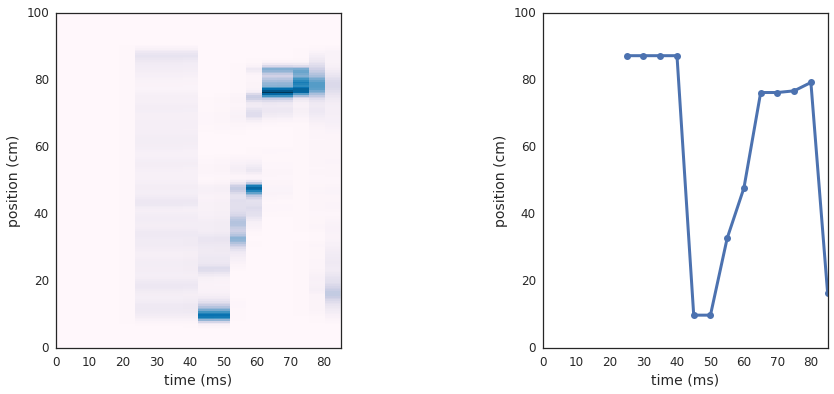

In [46]:
seqidx=67 #60
seq = binned_counts_5ms_SWR_cand_events[seqidx]
T, P, prob, PP = decode_swr_sequence(seq,ss_pfsmooth,ss_pfbincenters,pindex,t_bin=t_bin,tau=tau,showfig=True,shuffletype='none')
            
corrXYprob(T,P,prob)

## Now re-do replay decision based on an event-by-event comparison to shuffle distributions

In [1]:
# check the 95th percentile threshold for the correlation coeff for a single event, using unit-id shuffle

seqidx = 6
N_shuffl = 1000

seq = binned_counts_5ms_SWR_cand_events[seqidx]
T, P, prob, PP = decode_swr_sequence(seq,ss_pfsmooth,ss_pfbincenters,pindex,t_bin=t_bin,tau=tau,showfig=False,shuffletype='none')
eventcorr = corrXYprob(T,P,prob)
print('event corr: {}'.format(eventcorr))
weighted_corr_unit_shuffl = np.zeros((N_shuffl,1))
for jj in np.arange(0,N_shuffl):
    T, P, prob, PP = decode_swr_sequence(seq,ss_pfsmooth,ss_pfbincenters,pindex,t_bin=t_bin,tau=tau,showfig=False,shuffletype='unit-event')
    weighted_corr_unit_shuffl[jj] = corrXYprob(T,P,prob)

th = np.percentile(np.abs(weighted_corr_unit_shuffl),95) # 95th percentile for [absolute] correlations of shuffles
print('absolute 95 percentile threshold: {}'.format(th))

sns.distplot(weighted_corr_unit_shuffl,bins=30,kde=False)

NameError: name 'binned_counts_5ms_SWR_cand_events' is not defined

In [ ]:
# use unit-id shuffle for each event, and declare an event replay if its correlation is greater than 95 % of the shuffled corrs

N_shuffl = 100

dfindex = SWR_cand_events.index

for kk,seq in enumerate(binned_counts_5ms_SWR_cand_events):
    T, P, prob, PP = decode_swr_sequence(seq,ss_pfsmooth,ss_pfbincenters,pindex,t_bin=t_bin,tau=tau,showfig=False,shuffletype='none')
    eventcorr = corrXYprob(T,P,prob)
    weighted_corr_unit_shuffl = np.zeros((N_shuffl,1))
    for jj in np.arange(0,N_shuffl):
        T, P, prob, PP = decode_swr_sequence(seq,ss_pfsmooth,ss_pfbincenters,pindex,t_bin=t_bin,tau=tau,showfig=False,shuffletype='unit-event')
        weighted_corr_unit_shuffl[jj] = corrXYprob(T,P,prob)

    th = np.percentile(np.abs(weighted_corr_unit_shuffl),95) # 95th percentile for [absolute] correlations of shuffles
    
    dfidx = dfindex[kk]
    SWR_cand_events.ix[dfidx,'corr'] = eventcorr
    if np.abs(eventcorr) >= th:
        SWR_cand_events.ix[dfidx,'replay'] = True
    else:
        SWR_cand_events.ix[dfidx,'replay'] = False

print('{} out of {} candidate events classified as replay (trajectory) events...'.format(np.count_nonzero(SWR_cand_events.replay),SWR_cand_events.replay.count()))


/home/ubuntu/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/ubuntu/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


In [ ]:
SWR_cand_events

## Now train HMM using BVR data, and evaluate SWR events in model


In [ ]:
import pickle

with open('data/BVR_train2rn_noswr_th1.pickle', 'rb') as f:
    BVR_train2 = pickle.load(f)  
    
with open('data/BVR_test2rn_noswr_th1.pickle', 'rb') as f:
    BVR_test2 = pickle.load(f)

In [ ]:
import sys
sys.path.insert(0, '../')

import numpy as np
import pandas as pd
import pickle 
import seaborn as sns
#import yahmm as ym
from hmmlearn import hmm # see https://github.com/ckemere/hmmlearn


from matplotlib import pyplot as plt
from pandas import Series, DataFrame

from efunctions import * # load my helper functions

%matplotlib inline

In [ ]:
def yahmmdata_to_hmmlearn_data(yahmmdata):
    SequenceLengths = []

    tmp = np.array(yahmmdata)
    num_sequences = tmp.shape[0]
    for ss in np.arange(0,num_sequences):
        SequenceLengths.append(len(tmp[ss]))

    numCells = np.array(tmp[0]).shape[1]
    TotalSequenceLength = np.array(SequenceLengths).sum()

    StackedData = np.zeros((TotalSequenceLength,numCells))
    rr = 0;
    for ss in np.arange(0,num_sequences):
        StackedData[rr:rr+SequenceLengths[ss],:] = np.array(tmp[ss])
        rr = rr+SequenceLengths[ss]
    
    print("{0} sequences stacked for hmmlearn".format(num_sequences))
    
    return SequenceLengths, StackedData


In [ ]:
TrainingSequenceLengths2, StackedTrainingData2 = yahmmdata_to_hmmlearn_data(BVR_train2)
TestingSequenceLengths2, StackedTestingData2 = yahmmdata_to_hmmlearn_data(BVR_test2)

In [ ]:
NStates = 15

hmm15_2 = hmm.PoissonHMM(n_components=NStates, n_iter=20, init_params='stm', params='stm', verbose=True)
hmm15_2.fit(StackedTrainingData2, lengths=TrainingSequenceLengths2)

tmat = hmm15_2.transmat_

# sort model states:
new_order = [0]
rem_states = np.arange(1,NStates).tolist()
cs = 0

for ii in np.arange(0,NStates-1):
    nstilde = np.argmax(tmat[cs,rem_states])
    ns = rem_states[nstilde]
    rem_states.remove(ns)
    cs = ns
    new_order.append(cs)
    
tmatnew = tmat[:, new_order][new_order]
meanmat = hmm15_2.means_[new_order,:]

sns.set(rc={'figure.figsize': (4, 12),'lines.linewidth': 2, 'font.size': 18, 'axes.labelsize': 16, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
#f, (ax1, ax2) = plt.subplots(1,2)
f, ax1 = plt.subplots(1,1)

#ax2.imshow(meanmat.T,interpolation="none", cmap='PuBu')    
ax1.imshow(tmatnew,interpolation="none", cmap='PuBu')
#ax2.set_title('After sorting state labels')
#ax1.set_title('After sorting state labels')
#ax2.grid(False)
ax1.grid(False)
#ax2.set_xlabel('state')
#ax2.set_ylabel('cell')
ax1.set_xticklabels('')
ax1.set_yticklabels('')
#saveFigure("figures/transmat-m20.pdf")

In [ ]:
def get_replay_score_from_hmmlearn( hmmlearnModel, pth, obs ):
    # pth is a list of state indices, obs is a list (seq len) of lists (num cells) of nparray(rate)
    #P = np.exp(ymModel.dense_transition_matrix())
    logP = np.log(hmmlearnModel.transmat_)
    logPseq = 0
    logPctx = 0
    for ii in np.arange( 0, len(pth)-1 ):
        # add transition probability to sequence score:
        logPseq += logP[pth[ii],pth[ii+1]]
        # add memoryless observation likelihood to contextual score:
        logPctx += hmmlearnModel.score(obs[ii,:]) # memoryless map probability per symbol FFFB! What about prior state probs?
        #logPctx += np.log(hmmlearnModel.predict_proba(obs[ii,:])[0][hmmlearnModel.decode(obs[ii,:])[1][0]]) # memoryless map probability per symbol FFFB! What about prior state probs?model.predict_proba(obs[ii-1,:])[0][model.decode(obs[ii-1,:])[1][0]]
        #print(logPctx)
    logPctx += hmmlearnModel.score(obs[-1,:]) # memoryless map probability per symbol
    #logPctx += np.log(hmmlearnModel.predict_proba(obs[-1,:])[0][hmmlearnModel.decode(obs[-1,:])[1][0]]) # memoryless map probability per symbol FFFB! What about prior state probs?model.predict_proba(obs[ii-1,:])[0][model.decode(obs[ii-1,:])[1][0]]
    
    return logPseq/len(pth), logPctx/len(pth)

In [ ]:
# compute replay scores on all candidate events, and compare to trajectory shuffle:
from random import shuffle

SWRSequenceLengths, StackedSWRData = yahmmdata_to_hmmlearn_data(binned_counts_5ms_SWR_cand_events)

myStackedDataSeq = StackedSWRData*50 # note scaling here to make decoding time match up between obs and model
myStackedSeqLengths = SWRSequenceLengths

scores_seq2 = np.zeros(len(myStackedSeqLengths))
scores_ctx2 = np.zeros(len(myStackedSeqLengths))
scores_shfl_seq2 = np.zeros(len(myStackedSeqLengths))
scores_shfl_ctx2 = np.zeros(len(myStackedSeqLengths))

ulen2 = []

seqlimits = np.cumsum(np.array([0] + myStackedSeqLengths))
for ee in np.arange(0,len(myStackedSeqLengths)):
    obs = myStackedDataSeq[seqlimits[ee]:seqlimits[ee+1],:]
    lp, pth = hmm15_2.decode(obs,algorithm='map')
    trj_shfl_idx = np.arange(0,len(pth))
    shuffle(trj_shfl_idx)
    pth_trj_shfl = [pth[i] for i in trj_shfl_idx]
    obs_trj_shfl = np.array([obs[i] for i in trj_shfl_idx])
    
    scores_seq2[ee], scores_ctx2[ee] = get_replay_score_from_hmmlearn(hmm15_2, pth, obs)
    scores_shfl_seq2[ee], scores_shfl_ctx2[ee] = get_replay_score_from_hmmlearn(hmm15_2, pth_trj_shfl, obs_trj_shfl)
    #print(ee)
    
    ulen2.append(len(set(pth))) # number of unique states visited in path
    
slen2 = myStackedSeqLengths # sequence lengths


In [ ]:
print(np.array(scores_seq2).mean())
print(np.array(scores_shfl_seq2).mean())
print("Average number of unique states visited per sequence: {0}".format(np.array(ulen2).mean()))

In [ ]:
sns.set(rc={'figure.figsize': (5, 3.5),'lines.linewidth': 3, 'font.size': 16, 'axes.labelsize': 14, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style("white")
f, ax = plt.subplots(1,1)

#ax.scatter(np.exp(scores_seq2)*np.array(ulen2), scores_ctx2, s=80, c='k', marker='o',facecolors='none', edgecolors='c',linewidth=1)
#ax.scatter(np.exp(scores_shfl_seq2)*np.array(ulen2), scores_shfl_ctx2, c='c', s=80, marker='x',facecolors='none', edgecolors='k',linewidth=1)

ax.scatter(np.exp(scores_seq2)*np.array(ulen2), scores_ctx2, s=80, c='k', marker='o',facecolors='none', edgecolors='c',linewidth=1)
ax.scatter(np.exp(scores_shfl_seq2)*np.array(ulen2), scores_shfl_ctx2, c='c', s=80, marker='x',facecolors='none', edgecolors='k',linewidth=1)

ax.set_xlabel('exp(q_seq)')
ax.set_ylabel('q_ctx')
ax.legend(['candidate sequences', 'trajectory shuffled'])
ax.set_title('novel sequence score on subsequences of hc-3 data')

#saveFigure("figures/replay-score-m20state-embc16.pdf")

In [ ]:
SWR_cand_events.s_seq = scores_seq2
SWR_cand_events.s_ctx = scores_ctx2

In [ ]:
#SWR_cand_events

## below we look at the replay scores of "replay" vs "non-replay" candidate events...

In [ ]:
np.mean(SWR_cand_events.s_seq[SWR_cand_events.replay==True])

In [ ]:
np.mean(SWR_cand_events.s_seq[SWR_cand_events.replay==False])

In [ ]:
sns.distplot(np.exp(SWR_cand_events.s_seq[SWR_cand_events.replay==True]),bins=20)
sns.distplot(np.exp(SWR_cand_events.s_seq[SWR_cand_events.replay==False]),bins=20)

In [ ]:
tmpidx = SWR_cand_events.replay.tolist()
replayidx = np.where(tmpidx)[0]
nonreplayidx = np.where(~np.array(tmpidx))[0]

## just a few more things to check

In [ ]:
replayidx

In [ ]:
nonreplayidx

In [ ]:
for kk in replayidx:
    seq = binned_counts_5ms_SWR_cand_events[kk]
    T, P, prob, PP = decode_swr_sequence(seq,ss_pfsmooth,ss_pfbincenters,pindex,t_bin=t_bin,tau=tau,showfig=True,shuffletype='none')
          

In [ ]:
for kk in nonreplayidx:
    seq = binned_counts_5ms_SWR_cand_events[kk]
    T, P, prob, PP = decode_swr_sequence(seq,ss_pfsmooth,ss_pfbincenters,pindex,t_bin=t_bin,tau=tau,showfig=True,shuffletype='none')
          

In [ ]:
seqidx=149 #60
seq = binned_counts_5ms_SWR_cand_events[seqidx]
T, P, prob, PP = decode_swr_sequence(seq,ss_pfsmooth,ss_pfbincenters,pindex,t_bin=t_bin,tau=tau,showfig=True,shuffletype='none')
            
print('corr: {}'.format(corrXYprob(T,P,prob)))
print('exp(seq): {}'.format(np.exp(scores_seq2[seqidx])))

In [ ]:
seqidx=98 #60
seq = binned_counts_5ms_SWR_cand_events[seqidx]
T, P, prob, PP = decode_swr_sequence(seq,ss_pfsmooth,ss_pfbincenters,pindex,t_bin=t_bin,tau=tau,showfig=True,shuffletype='none')
            
print('corr: {}'.format(corrXYprob(T,P,prob)))
print('exp(seq): {}'.format(np.exp(scores_seq2[seqidx])))

## plot replay scores vs corr coeffs


In [ ]:
sns.set(rc={'figure.figsize': (12, 4),'lines.linewidth': 2, 'font.size': 18, 'axes.labelsize': 16, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style("white")
f, ax1 = plt.subplots(1,1)

print('NOTE! Here the traj shuffled events are shown with their original (unshuffled) weighted corr, so\n that only the replay score is relevant here...')

x = SWR_cand_events.s_seq.values
y = SWR_cand_events['corr'].values
plt.scatter(x,y,color='orange')
plt.scatter(scores_shfl_seq2,y,color='m',s=5)
plt.xlabel('replay score (s_seq)')
plt.ylabel('weighted corr')
# add replay events as different color
x = SWR_cand_events[SWR_cand_events.replay==True].s_seq.values
y = (SWR_cand_events[SWR_cand_events.replay==True])['corr'].values
plt.scatter(x,y,color='c',s=40)
plt.legend(['non-replay', 'traj shuffled', 'replay'])

